In [1]:
import isaacgym
import isaacgymenvs
from isaacgymenvs.utils.reformat import omegaconf_to_dict, print_dict
from isaacgymenvs.utils.utils import set_np_formatting, set_seed
from isaacgymenvs.utils.rlgames_utils import RLGPUEnv, RLGPUAlgoObserver, get_rlgames_env_creator

from rl_games.common import env_configurations, vecenv
from rl_games.torch_runner import Runner
from rl_games.algos_torch import model_builder

from omegaconf import DictConfig, OmegaConf

Importing module 'gym_37' (/home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_37.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/home/hz/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 1.12.1+cu102
Device count 1
/home/hz/devel/isaacgym/python/isaacgym/_bindings/src/gymtorch
Using /home/hz/.cache/torch_extensions/py37_cu102 as PyTorch extensions root...
Emitting ninja build file /home/hz/.cache/torch_extensions/py37_cu102/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module gymtorch...


/home/hz/devel/isaacgym/python/isaacgym/torch_utils.py:135: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def get_axis_params(value, axis_idx, x_value=0., dtype=np.float, n_dims=3):
2023-04-25 15:30:48,196 - INFO - logger - logger initialized
<unknown>:6: DeprecationWarning: invalid escape sequence \*


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


/home/hz/miniconda3/envs/rlgpu/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  tensorboard.__version__


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cfg = OmegaConf.load("cfg/config.yaml")
cfg.task_name="TrifingerNYU"
cfg.num_envs=1
cfg.task=OmegaConf.load("cfg/task/TrifingerNYU.yaml")

In [4]:
device = cfg.sim_device

In [5]:
def create_env_thunk(**kwargs):
        envs = isaacgymenvs.make(
            
            cfg.seed,
            cfg.task,
            cfg.num_envs,
            cfg.sim_device,
            cfg.rl_device,
            headless=True,
            cfg=cfg,
            **kwargs,
        )
        return envs

In [6]:
envs = create_env_thunk()

[Warning] [carb.gym.plugin] useGpu is set, forcing single scene (0 subscenes)
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled


/home/hz/miniconda3/envs/rlgpu/lib/python3.7/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Trifinger Robot Asset: 
	 Number of bodies: 23
	 Number of shapes: 39
	 Number of dofs: 9
	 Number of actuated dofs: 9
Trifinger Table Asset: 
	 Number of bodies: 2
	 Number of shapes: 1
Trifinger Boundary Asset: 
	 Number of bodies: 1
	 Number of shapes: 41
Using VHACD cache directory '/home/hz/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/hz/devel/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/int_sim.stl'
Found existing convex decomposition for mesh '/home/hz/devel/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/prox-sim.stl'
Found existing convex decomposition for mesh '/home/hz/devel/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/tip_link_sim.stl'
Found existing convex decomposition for mesh '/home/hz/devel/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/tip_sim.stl'
Found existing convex decomposition for mesh '/home/hz/d

In [7]:
# get fingertip states
N = 500
action_buffer = torch.zeros(N, 9).to(device)
ftip_pos_buffer = torch.zeros(N, 9).to(device)
ftip_vel_buffer = torch.zeros(N, 9).to(device)
jacobian_buffer = torch.zeros(N, 9, 9).to(device)
dof_vel_buffer = torch.zeros(N, 9).to(device)

for n in range(N):
    action = torch.rand(1, 9).to(device) * 2 - 1
    obs, rwds, resets, info = envs.step(torch.rand(1, 9).to(cfg.sim_device) * 2 - 1)
    action_buffer[n] = action
    
    q = envs._dof_position
    dq = envs._dof_velocity
    dof_vel_buffer[n] = dq[0]
    
    fingertip_state = envs._rigid_body_state[:, envs._fingertip_indices]
    fingertip_position = fingertip_state[:, :, 0:3].reshape(envs.num_envs, 9)
    fingertip_velocity = fingertip_state[:, :, 7:10].reshape(envs.num_envs, 9)
    ftip_pos_buffer[n] = fingertip_position[0]
    ftip_vel_buffer[n] = fingertip_velocity[0]
    
    fid = [5, 12, 19]
    jacobian_fingertip_linear = envs._jacobian[:, fid, :3, :]
    jacobian_fingertip_linear = jacobian_fingertip_linear.view(
                    envs.num_envs, 
                    3 * envs._dims.NumFingers.value, 
                    envs._dims.GeneralizedCoordinatesDim.value)
    jacobian_buffer[n] = jacobian_fingertip_linear[0]

In [17]:
ftip_pos_buffer_np = ftip_pos_buffer.cpu().numpy()
ftip_vel_buffer_np = ftip_vel_buffer.cpu().numpy()
jdq = torch.einsum('bij, bj -> bi', jacobian_buffer, dof_vel_buffer)
jdq_np = jdq.cpu().numpy()

In [18]:
dt = 0.02
ftip_vel_numdiff = np.diff(ftip_pos_buffer_np, axis=0) / dt
ftip_vel_numdiff = np.vstack((np.zeros((1, 9)), ftip_vel_numdiff))

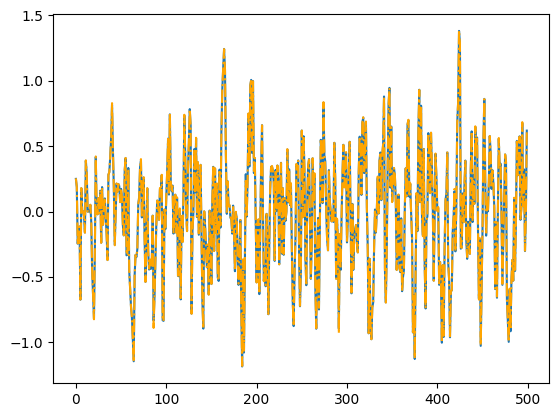

In [41]:
d = 0
# plt.plot(ftip_vel_numdiff[:, d])
plt.plot(ftip_vel_buffer_np[:, d])
plt.plot(jdq_np[:, d], color='orange', ls='-.')

In [7]:
import trifinger_simulation
import numpy as np
import pinocchio as pin

pybullet build time: May 20 2022 19:43:01


In [8]:
platform = trifinger_simulation.TriFingerPlatform()
trifinger = platform.simfinger
rmodel = trifinger.kinematics.robot_model
rdata = trifinger.kinematics.data
ftip_id = trifinger.kinematics.tip_link_ids

In [9]:
q1_np = q1[0].cpu().numpy()
dq1_np = dq1[0].cpu().numpy()

In [10]:
trifinger.kinematics.forward_kinematics(q_np)

[[0.09378661423891241, 0.05057204570721733, -0.02651110164976367],
 [-0.002945821003218333, -0.10625958173664683, -0.026151022087087444],
 [-0.09068988308828807, 0.05593559329825963, -0.026511101133743137]]

In [12]:
pin.computeJointJacobians(rmodel, rdata, q_np)
pin.framesForwardKinematics(rmodel, rdata, q_np)
J_ = []
for i in range(3):
    J_.append(pin.getFrameJacobian(
        rmodel,
        rdata,
        ftip_id[i],
        pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
    )[:3, :])
J = np.vstack(J_)

In [13]:
J @ dq_np # pinocchio, local world aligned

array([-0.10903541,  0.1157873 ,  0.39606528,  0.19653007,  0.06740448,
        0.52209394, -0.04569383, -0.15214085,  0.39611274])

In [14]:
jacobian_fingertip_linear[0] @ dq[0] # isaac

tensor([-0.1090,  0.1158,  0.3961,  0.1965,  0.0674,  0.5221, -0.0457, -0.1521,
         0.3961], device='cuda:0')

In [15]:
fingertip_velocity # isaac direct readings

tensor([[-0.0997,  0.1164, -0.0268,  0.1915,  0.0569, -0.0390, -0.0509, -0.1443,
         -0.0268]], device='cuda:0')